In [3]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


In [107]:
df = pd.read_csv('https://momo.isciii.es/public/momo/data')
df.to_csv('/tmp/momo.csv')

df.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-19,1060,1060.0,1060.0,1026.5,945.94,1135.31
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-20,970,970.0,970.0,1029.5,945.94,1123.58
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-21,1000,1000.0,1000.0,1031.0,934.90,1122.65
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-22,1005,1005.0,1005.0,1037.0,934.90,1136.41
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-23,1082,1082.0,1082.0,1031.5,928.69,1136.41


In [222]:
import janitor
import datetime



def pipeline_basic(df):
    """ Basic filtering, using janitor """
    LISTA_COLUMNAS_A_BORRAR = ['Unnamed: 0',
                           'defunciones_observadas_lim_inf',
                           'defunciones_observadas_lim_sup',
                           'defunciones_esperadas',
                           'defunciones_esperadas_q01',
                           'defunciones_esperadas_q99']
    return (
        df
        # Quitar: columnas
        .remove_columns(LISTA_COLUMNAS_A_BORRAR)
        .clean_names()
        # Filtrar: filas que no sean de ambito nacional
        .filter_on('ambito       == "nacional" '  )
        .filter_on('nombre_gedad == "todos"    '  )
        .filter_on('nombre_sexo  == "todos"    '  )
        # Enriquecer: fechas con columnas de años, mes y año-mes
        .rename_column( "fecha_defuncion", "date")
        .to_datetime('date')
        .join_apply(lambda x: x['date'].strftime('%Y')    , new_column_name="date_year"       )
        .join_apply(lambda x: x['date'].strftime('%m')    , new_column_name="date_month"      )
        .join_apply(lambda x: x['date'].strftime('%U')    , new_column_name="date_week"       )
        .join_apply(lambda x: x['date'].strftime('%Y-%m') , new_column_name="date_year_month" )
        .join_apply(lambda x: x['date'].strftime('%Y-%U') , new_column_name="date_year_week"  )
        .set_index('date')
    )

def pipeline_agregado_anual(periodo_de_tiempo,df,year):
    return (
        df
        .filter_on('date_year == "'+year+'"'  )
        .groupby_agg( by='date_'+periodo_de_tiempo, agg='sum', agg_column_name="defunciones_observadas", new_column_name="agregados")
        .rename_column( "agregados", year)
        .join_apply(lambda x: x['date_'+periodo_de_tiempo]  , new_column_name=periodo_de_tiempo )
        .set_index('date_'+periodo_de_tiempo)
        [[periodo_de_tiempo,year]]
        .drop_duplicates()        
    )

def pipeline_comparativa_anual(periodo_de_tiempo,df_2018,df_2019,df_2020):
    """ Mergea tres dataframes de año, por periodo de tiempo"""
    return  (
    df_2018
    .merge( df_2019, on=periodo_de_tiempo, how='right')
    .merge( df_2020, on=periodo_de_tiempo, how='left')
    .sort_naturally(periodo_de_tiempo)
    .set_index(periodo_de_tiempo)
    )

def extraer_defunciones_anuales_por_periodo(periodo_de_tiempo):
    """Extrae el cuadro de comparativa por week, or year """
    # Sacamos los datos y limpiamos
    df       = pd.read_csv('/tmp/momo.csv')
    df_basic = pipeline_basic(df)

    # Sacamos los datos agrupados por años
    muertes_2018  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2018')
    muertes_2019  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2019')
    muertes_2020  = pipeline_agregado_anual(periodo_de_tiempo,df=df_basic,year='2020')

    # Generamos un solo cuadro, con columna por año
    df_comparativa_años  = pipeline_comparativa_anual(periodo_de_tiempo,muertes_2018,muertes_2019,muertes_2020)
    return df_comparativa_años

df_muertes_anuales_por_semana = extraer_defunciones_anuales_por_periodo("week")
df_muertes_anuales_por_mes    = extraer_defunciones_anuales_por_periodo("month")

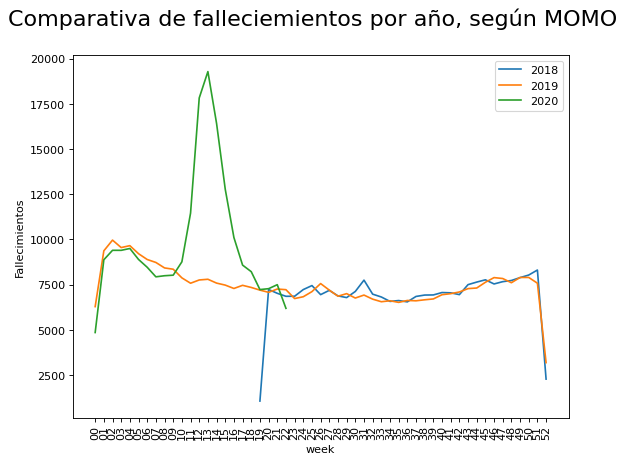

,2018,2019,2020,resta 2020 y 2019
week,,,,
00,nan,"6,282","4,849","-1,433"
01,nan,"9,368","8,874",-494
02,nan,"9,960","9,396",-564
03,nan,"9,548","9,395",-153
04,nan,"9,654","9,497",-157
05,nan,"9,209","8,891",-318
06,nan,"8,888","8,459",-429
07,nan,"8,725","7,930",-795
08,nan,"8,422","7,990",-432


In [228]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

import numpy as np

periodo_de_tiempo="week"
df = extraer_defunciones_anuales_por_periodo(periodo_de_tiempo) 

fig = plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)

for ca in ['2018','2019','2020']:
    plt.plot(df[ca])
    plt.legend(df.columns)
    plt.xlabel(periodo_de_tiempo)
    plt.ylabel("Fallecimientos")
    fig.suptitle('Comparativa de falleciemientos por año, según MOMO', fontsize=20)
plt.show()


df['resta 2020 y 2019'] = df['2020'] - df['2019']

df.style.format({"2020": "{:20,.0f}", 
                          "2018": "{:20,.0f}", 
                          "2019":  "{:20,.0f}", 
                          "resta 2020 y 2019": "{:20,.0f}", }).background_gradient(cmap='Wistia',subset=['resta 2020 y 2019'])



In [204]:
"""
import pdpipe as pdp

df = pd.read_csv('/tmp/momo.csv')

pipeline = pdp.ColDrop("Inicio", exraise=False)

for column in LISTA_COLUMNAS_A_BORRAR: 
    pipeline += pdp.ColDrop(column, exraise=True)

pipeline += pdp.RowDrop({ 'nombre_gedad': lambda x: x == 'todos'    })    
pipeline += pdp.RowDrop({ 'nombre_sexo' : lambda x: x == 'todos'    })    
pipeline += pdp.RowDrop({ 'ambito'      : lambda x: x == 'nacional' })    
pipeline += pdp.ColRename({'fecha_defuncion': 'date'})


print(pipeline)   
df = pipeline(df)
df
"""


'\nimport pdpipe as pdp\n\ndf = pd.read_csv(\'/tmp/momo.csv\')\n\npipeline = pdp.ColDrop("Inicio", exraise=False)\n\nfor column in LISTA_COLUMNAS_A_BORRAR: \n    pipeline += pdp.ColDrop(column, exraise=True)\n\npipeline += pdp.RowDrop({ \'nombre_gedad\': lambda x: x == \'todos\'    })    \npipeline += pdp.RowDrop({ \'nombre_sexo\' : lambda x: x == \'todos\'    })    \npipeline += pdp.RowDrop({ \'ambito\'      : lambda x: x == \'nacional\' })    \npipeline += pdp.ColRename({\'fecha_defuncion\': \'date\'})\n\n\nprint(pipeline)   \ndf = pipeline(df)\ndf\n'

In [2]:
def get_momo():
    return pd.read_csv('https://momo.isciii.es/public/momo/data')

def get_momo_by_year():
    kk = get_momo()

    # Enrich data
    kk = kk[(kk['ambito']=='nacional') &  (kk['nombre_gedad']=='todos')  &    (kk['nombre_sexo' ] =='todos') ]
    kk['date'] =kk['fecha_defuncion'] 
    kk['date'] = pd.to_datetime(kk['date'])
    kk['year'], kk['month'] = kk['date'].dt.year, kk['date'].dt.month
    kk["month"] = kk.month.map("{:02}".format)

    kk['year-month'] =  kk['year'].astype(str) + "-" +  kk['month'].astype(str)

    ss = kk[['defunciones_observadas','year-month']].groupby(['year-month'])['defunciones_observadas'].agg('sum').to_frame()
    ss['month'] = ss.index.astype(str).str[5:7] 
    ss['year-month'] = ss.index

    muertes_2018 = ss[(ss['year-month'] >= '2018-01') & (ss['year-month'] < '2019-01')][['defunciones_observadas','month']]
    muertes_2019 = ss[(ss['year-month'] >= '2019-01') & (ss['year-month'] < '2020-01')][['defunciones_observadas','month']]
    muertes_2020 = ss[(ss['year-month'] >= '2020-01') & (ss['year-month'] < '2021-01')][['defunciones_observadas','month']]

    muertes_2018=muertes_2018.rename(columns = {'defunciones_observadas':'2018'})
    muertes_2019=muertes_2019.rename(columns = {'defunciones_observadas':'2019'})
    muertes_2020=muertes_2020.rename(columns = {'defunciones_observadas':'2020'})


    muertes_2018 = muertes_2018.reset_index(drop=True)
    muertes_2019 = muertes_2019.reset_index(drop=True)
    muertes_2020 = muertes_2020.reset_index(drop=True)

    muertes_temp = pd.merge(  muertes_2019,muertes_2018, on="month", how='left')
    muertes_temp
    muertes_temp2 =  pd.merge(  muertes_2019,muertes_2020, on="month", how='left')
    muertes_temp2
    muertes_totales = pd.merge(  muertes_temp, muertes_temp2)
    muertes_totales.index=muertes_totales
    muertes_totales.index =muertes_totales['month'] 
    del muertes_totales['month']
    return muertes_totales[['2018','2019','2020']]

df=get_momo_by_year()

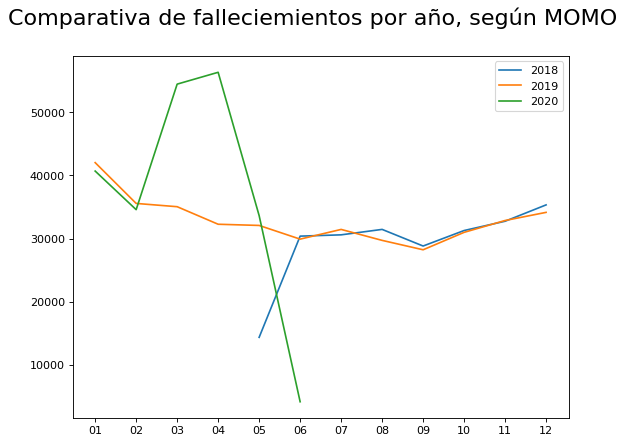

,2018,2019,2020,resta 2020 y 2019
month,,,,
01,nan,"42,034","40,697","-1,337"
02,nan,"35,571","34,584",-987
03,nan,"35,052","54,467","19,415"
04,nan,"32,273","56,342","24,069"
05,"14,358","32,084","33,643","1,559"
06,"30,389","29,915","4,157","-25,758"
07,"30,595","31,454",nan,nan
08,"31,457","29,718",nan,nan
09,"28,824","28,229",nan,nan


In [3]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

import numpy as np


fig = plt.figure(figsize=(8, 6), dpi=80)
for ca in ['2018','2019','2020']:
    plt.plot(df[ca])
    plt.legend(df.columns)
    fig.suptitle('Comparativa de falleciemientos por año, según MOMO', fontsize=20)
plt.show()

df['resta 2020 y 2019'] = df['2020'] - df['2019']
df

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]


df.style.format({"2020": "{:20,.0f}", 
                          "2018": "{:20,.0f}", 
                          "2019":  "{:20,.0f}", 
                          "resta 2020 y 2019": "{:20,.0f}", }).background_gradient(cmap='Wistia',subset=['resta 2020 y 2019'])



In [229]:
df.info
df.describe()

,2018,2019,2020,resta 2020 y 2019
count,34.000000,53.000000,23.000000,23.000000
mean,6880.352941,7440.358491,9777.478261,1721.347826
std,1401.404531,1051.417945,3595.561037,3704.798922
min,1060.000000,3185.000000,4849.000000,-1433.000000
25%,6853.750000,6858.000000,7960.000000,-430.500000
50%,7032.000000,7286.000000,8760.000000,30.000000
75%,7526.500000,7836.000000,9800.000000,1967.500000
max,8306.000000,9960.000000,19279.000000,11484.000000


In [6]:
# Aux functions
def print_categorical_variables(df):
    """ Get a dict with categorical variables"""    
    my_dict = {}
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    # Show categorical values
    categorical = list(set(cols) - set(num_cols))
    for i in categorical : 
        if 'echa' not in i.lower() : my_dict[i] = df[i].unique()         
    return my_dict
df = get_momo()
my_dict = print_categorical_variables(df)
my_dict

{'cod_ambito': array([nan, 'AN', 'AR', 'AS', 'IB', 'CN', 'CB', 'CL', 'CM', 'CT', 'VC',
        'EX', 'GA', 'MD', 'MC', 'NC', 'PV', 'RI', 'CE', 'ML'], dtype=object),
 'cod_sexo': array(['all', '1', '6'], dtype=object),
 'nombre_sexo': array(['todos', 'hombres', 'mujeres'], dtype=object),
 'cod_gedad': array(['all', 'menos_65', '65_74', 'mas_74'], dtype=object),
 'nombre_ambito': array([nan, 'Andalucía', 'Aragón', 'Asturias, Principado de',
        'Balears, Illes', 'Canarias', 'Cantabria', 'Castilla y León',
        'Castilla - La Mancha', 'Cataluña', 'Comunitat Valenciana',
        'Extremadura', 'Galicia', 'Madrid, Comunidad de',
        'Murcia, Región de', 'Navarra, Comunidad Foral de', 'País Vasco',
        'Rioja, La', 'Ceuta', 'Melilla'], dtype=object),
 'nombre_gedad': array(['todos', 'edad < 65', 'edad 65-74', 'edad > 75'], dtype=object),
 'ambito': array(['nacional', 'ccaa'], dtype=object)}